In [6]:
###Required packages
import numpy as np
from hyperopt import hp, fmin, tpe
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import seaborn as sns

## P-Aminostyrene Synthesis Model

In [27]:
###Helper functions
def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss
    
def name_converter(A):
    name = ''
    for i in range(3):
        arch = A[i]
        if arch == (1, 0, 0, 0, 0):
            name += 'A1'
        elif arch == (0, 1, 0, 0, 0):
            name += 'A2'
        elif arch == (0, 0, 1, 0, 0):
            name += 'R1'
        elif arch == (0, 0, 0, 1, 0):
            name += 'R2'
        elif arch == (0, 0, 0, 0, 1):
            name += 'N'
        name += '-'
    return name[:-1]

###Model definition
def p_aminostyrene(t, y, ydot, params):
    #Parse input parameters
    chorismate, pa1, pa2, pa3, paf, paca_int, paca_ext, promoter1, papA_mrna, papA_uf, papA, papB_mrna, papB_uf, papB, papC_mrna, papC_uf, papC, deaminase, promoter2, laao_mrna, laao_uf, laao, promoter3, eff_mrna, eff_uf, eff, j1, j2 = y
    architecture, thetas, ks = params
    theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
    theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
    k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
    k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]
    n = 2 #Fix n based on dimerization

    #Cellular constants
    chorismate_production_rate = 1100. #range [2E2, 2E3]
    deaminase_production_rate =  1E1 #range [1E0, 1E2]
    mrna_degradation_rate = 3E-3 #range [3E-4, 3E-2]
    protein_degradation_rate = 2E-4 #range [2E-5, 2E-3]
    protein_folding_rate = 2E0 #range [2E-1, 2E1] 
    dilution_rate = 5.79E-4
    dna_duplication_rate = 5.78E-4
    avogadro = 6.0221408e+23
    cell_volume = 2.5E-15

    ki = 5E-5 #range [1E-5, 1E-4]
    tl = 50 #range [1E1, 1E2]
    tp = 50 #range [1E1, 1E2]
    ta = 5E-4 #range [1E-4, 1E-3]
    toxicity_factor = ki/(ki + (ta*paca_int + tp*eff + tl*laao))
    
    pap_mrnalength = 3400
    eff_mrnalength = 2900
    laao_mrnalength = 1600
    ribosome_elongation = 20
    tsn_init = 2E-1

    #Enzyme kinetic parameters
    enzyme_kcat = 5E0 #range [5E-1, 5E1]
    enzyme_km = 1E-6 #range [1E-7, 1E-5]
    papA_kcat = 0.2975
    papA_km = 0.056
    papB_kcat = 39
    papB_km = 0.38 
    papC_kcat = 20.44
    papC_km = 0.555
    laao_kcat = 1.29
    laao_km = 10.82
    deaminase_kcat = enzyme_kcat
    deaminase_km = enzyme_km
    efflux_rate = 275. #range [5E1, 5E2]

    #Kinetic pathway
    chorismate_biosynthesis = chorismate_production_rate * toxicity_factor
    deaminase_biosynthesis = deaminase_production_rate * toxicity_factor
    papA_catalyzed_biosynthesis = papA_kcat * papA * ((chorismate / avogadro) / cell_volume) / (papA_km + ((chorismate / avogadro) / cell_volume)) * toxicity_factor
    papB_catalyzed_biosynthesis = papB_kcat * ((pa1 / avogadro) / cell_volume) / (papB_km + ((pa1 / avogadro) / cell_volume)) * papB * toxicity_factor
    papC_catalyzed_biosynthesis = papC_kcat * papC * ((pa2 / avogadro) / cell_volume) / (papC_km + ((pa2 / avogadro) / cell_volume)) * toxicity_factor
    deaminase_catalyzed_biosynthesis = deaminase_kcat * deaminase * ((pa3 / avogadro) / cell_volume) / (deaminase_km + ((pa3 / avogadro) / cell_volume)) * toxicity_factor
    laao_catalyzed_biosynthesis = laao_kcat * laao * ((paf / avogadro) / cell_volume) / (laao_km + ((paf / avogadro) / cell_volume)) * toxicity_factor
    paca_external_efflux = eff * ((paca_int / avogadro) / cell_volume) * efflux_rate * toxicity_factor

    papA_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papA, theta_paf_prom1, n), activation(paca_int, k_paca_papA, theta_paca_prom1, n), repression(paf, k_paf_papA, theta_paf_prom1, n), repression(paca_int, k_paca_papA, theta_paca_prom1, n), k_paf_papA]))
    papB_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papB, theta_paf_prom1, n), activation(paca_int, k_paca_papB, theta_paca_prom1, n), repression(paf, k_paf_papB, theta_paf_prom1, n), repression(paca_int, k_paca_papB, theta_paca_prom1, n), k_paf_papB]))
    papC_mrna_txn = np.sum(architecture[0]*np.array([activation(paf, k_paf_papC, theta_paf_prom1, n), activation(paca_int, k_paca_papC, theta_paca_prom1, n), repression(paf, k_paf_papC, theta_paf_prom1, n), repression(paca_int, k_paca_papC, theta_paca_prom1, n), k_paf_papC]))
    laao_mrna_txn = np.sum(architecture[1]*np.array([activation(paf, k_paf_prom2, theta_paf_prom2, n), activation(paca_int, k_paca_prom2, theta_paca_prom2, n), repression(paf, k_paf_prom2, theta_paf_prom2, n), repression(paca_int, k_paca_prom2, theta_paca_prom2, n), k_paf_prom2]))
    eff_mrna_txn = np.sum(architecture[2]*np.array([activation(paf, k_paf_prom3, theta_paf_prom3, n), activation(paca_int, k_paca_prom3, theta_paca_prom3, n), repression(paf, k_paf_prom3, theta_paf_prom3, n), repression(paca_int, k_paca_prom3, theta_paca_prom3, n), k_paf_prom3]))

    papA_translation_rate = ((papA_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papB_translation_rate = ((papB_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papC_translation_rate = ((papC_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    laao_translation_rate = ((laao_mrna)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    eff_translation_rate = ((eff_mrna)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 

    ydot[0] = chorismate_biosynthesis - papA_catalyzed_biosynthesis - chorismate*dilution_rate #chorismate
    ydot[1] = papA_catalyzed_biosynthesis - papB_catalyzed_biosynthesis - pa1*dilution_rate #pa1
    ydot[2] = papB_catalyzed_biosynthesis - papC_catalyzed_biosynthesis - pa2*dilution_rate #pa2
    ydot[3] = papC_catalyzed_biosynthesis - deaminase_catalyzed_biosynthesis - pa3*dilution_rate #pa3
    ydot[4] = deaminase_catalyzed_biosynthesis -  laao_catalyzed_biosynthesis - paf*dilution_rate - paf*1.40E-5 #range [1.4E-6, 1.4E-4] #paf
    ydot[5] = laao_catalyzed_biosynthesis - paca_external_efflux - paca_int*dilution_rate #paca_int 
    ydot[6] = paca_external_efflux #paca_ext
    ydot[7] = promoter1*dna_duplication_rate - promoter1*dilution_rate #promoter1
    ydot[8] = papA_mrna_txn - papA_mrna * dilution_rate - papA_mrna * mrna_degradation_rate * toxicity_factor #papA_mrna
    ydot[9] = papA_translation_rate * toxicity_factor - papA_uf * protein_folding_rate * toxicity_factor - papA_uf * dilution_rate - papA_uf * protein_degradation_rate  * toxicity_factor #papA_uf 
    ydot[10] = papA_uf * protein_folding_rate * toxicity_factor - papA * dilution_rate - papA*protein_degradation_rate*toxicity_factor  #papA 
    ydot[11] = papB_mrna_txn - papB_mrna * dilution_rate - papB_mrna * mrna_degradation_rate * toxicity_factor #papB_mrna
    ydot[12] = papB_translation_rate * toxicity_factor - papB_uf * protein_folding_rate * toxicity_factor - papB_uf * dilution_rate - papB_uf * protein_degradation_rate  * toxicity_factor #papB_uf
    ydot[13] = papB_uf * protein_folding_rate * toxicity_factor - papB * dilution_rate - papB*protein_degradation_rate*toxicity_factor  #papB
    ydot[14] = papC_mrna_txn - papC_mrna * dilution_rate - papC_mrna * mrna_degradation_rate * toxicity_factor  #papC_mrna
    ydot[15] = papC_translation_rate * toxicity_factor - papC_uf * protein_folding_rate * toxicity_factor - papC_uf * dilution_rate - papC_uf * protein_degradation_rate  * toxicity_factor #papC_uf
    ydot[16] = papC_uf * protein_folding_rate * toxicity_factor - papC * dilution_rate - papC*protein_degradation_rate*toxicity_factor #papC
    ydot[17] = deaminase_biosynthesis - deaminase * dilution_rate #deaminase
    ydot[18] = promoter2*dna_duplication_rate - promoter2*dilution_rate #promoter2
    ydot[19] = laao_mrna_txn - laao_mrna * dilution_rate - laao_mrna * mrna_degradation_rate * toxicity_factor  #laao_mrna
    ydot[20] = laao_translation_rate * toxicity_factor - laao_uf * protein_folding_rate * toxicity_factor - laao_uf * dilution_rate - laao_uf * protein_degradation_rate  * toxicity_factor #laao_uf
    ydot[21] = laao_uf * protein_folding_rate * toxicity_factor - laao * dilution_rate - laao*protein_degradation_rate*toxicity_factor  #laao
    ydot[22] = promoter3*dna_duplication_rate - promoter3*dilution_rate #promoter3
    ydot[23] = eff_mrna_txn - eff_mrna * dilution_rate - eff_mrna * mrna_degradation_rate * toxicity_factor  #eff_mrna
    ydot[24] = eff_translation_rate * toxicity_factor - eff_uf * protein_folding_rate * toxicity_factor - eff_uf * dilution_rate - eff_uf * protein_degradation_rate  * toxicity_factor #eff_uf
    ydot[25] = eff_uf * protein_folding_rate * toxicity_factor - eff * dilution_rate - eff*protein_degradation_rate*toxicity_factor  #eff

    #J1 and J2
    ydot[26] = (chorismate_biosynthesis - paca_external_efflux)**2
    ydot[27] = papA_mrna_txn + papB_mrna_txn + papC_mrna_txn + laao_mrna_txn + eff_mrna_txn

###Define search space
architecture = [hp.choice('prom1', [[0, 0, 1, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]), hp.choice('prom2', [[1, 0, 0, 0, 0], [0, 0, 0, 1, 0], [0, 0, 0, 0, 1]]), hp.choice('prom3', [[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1]])]
space = (architecture, 
            [[hp.uniform('theta_paf_prom1', 1E-7, 10), hp.uniform('theta_paf_prom2', 1E-7, 10), hp.uniform('theta_paf_prom3', 1E-7, 10)], [hp.uniform('theta_paca_prom1', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10), hp.uniform('theta_paca_prom3', 1E-7, 10)]], 
            [[hp.uniform('k_paf_papA', 1E-7, 5), hp.uniform('k_paf_papB', 1E-7, 5), hp.uniform('k_paf_papC', 1E-7, 5), hp.uniform('k_paf_prom2', 1E-7, 5), hp.uniform('k_paf_prom3', 1E-7, 5)], [hp.uniform('k_paca_papA', 1E-7, 5), hp.uniform('k_paca_papB', 1E-7, 5), hp.uniform('k_paca_papC', 1E-7, 5), hp.uniform('k_paca_prom2', 1E-7, 5), hp.uniform('k_paca_prom3', 1E-7, 5)]])

###Objective function
def run_hyperopt(max_iters):
    losses = []
    params = []
    circuits = []

    #Define objective function
    def objective(args):
        architecture, thetas, ks = args
        #Integration conditions
        t = np.linspace(0, 1.73E5, 200) 
        y0 = np.array([0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
        extra_options = {'old_api': False, 'user_data': [architecture, thetas, ks], 'rtol':1E-4}
        ode_solver = ode('cvode', p_aminostyrene, **extra_options)
        solution = ode_solver.solve(t, y0)
        j1, j2 = solution.values.y[-1, -2:]
        j1, j2, loss = loss_biological(j1, j2, alpha1=1E-12, alpha2=1E-7)
        losses.append(loss)
        params.append([thetas, ks])
        circuits.append(architecture)
        return loss

    #Run hyperopt call
    best = fmin(objective, space, algo=tpe.suggest, max_evals=max_iters)
    #Create trajectory data frame
    theta_paf_prom1s, theta_paf_prom2s, theta_paf_prom3s, theta_paca_prom1s, theta_paca_prom2s, theta_paca_prom3s = [[], [], [], [], [], []]
    k_paf_papAs, k_paf_papBs, k_paf_papCs, k_paf_prom2s, k_paf_prom3s, k_paca_papAs, k_paca_papBs, k_paca_papCs, k_paca_prom2s, k_paca_prom3s = [[], [], [], [], [], [], [], [], [], []]
    for i in range(len(params)):
        thetas = params[0][0]
        ks = params[0][1]
        theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
        theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
        k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
        k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]

        theta_paf_prom1s.append(theta_paf_prom1)
        theta_paf_prom2s.append(theta_paf_prom2)
        theta_paf_prom3s.append(theta_paf_prom3)
        theta_paca_prom1s.append(theta_paca_prom1)
        theta_paca_prom2s.append(theta_paca_prom2)
        theta_paca_prom3s.append(theta_paca_prom3)
        k_paf_papAs.append(k_paf_papA)
        k_paf_papBs.append(k_paf_papB)
        k_paf_papCs.append(k_paf_papC)
        k_paf_prom2s.append(k_paf_prom2)
        k_paf_prom3s.append(k_paf_prom3)
        k_paca_papAs.append(k_paca_papA)
        k_paca_papBs.append(k_paca_papB)
        k_paca_papCs.append(k_paca_papC)
        k_paca_prom2s.append(k_paca_prom2)
        k_paca_prom3s.append(k_paca_prom3)

    landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'theta_paf_prom1':theta_paf_prom1s, 'theta_paf_prom2':theta_paf_prom2s, 'theta_paf_prom3':theta_paf_prom3s,
                'theta_paca_prom1':theta_paca_prom1s, 'theta_paca_prom2':theta_paca_prom2s, 'theta_paca_prom3':theta_paca_prom3,
                'k_paf_papA':k_paf_papAs, 'k_paf_papB':k_paf_papBs, 'k_paf_papC':k_paf_papCs, 'k_paf_prom2':k_paf_prom2s, 'k_paf_prom3':k_paf_prom3s,
                'k_paca_papA':k_paca_papAs, 'k_paca_papB':k_paca_papBs, 'k_paca_papC':k_paca_papCs, 'k_paca_prom2':k_paca_prom2s, 'k_paca_prom3':k_paca_prom3s})

    best_loss = 1E5
    best_circuit = 'Initial'
    best_losses = []
    best_losses_circuits = []
    for i in range(len(landscape)):
        if landscape.loss[i] < best_loss:
            best_loss = landscape.loss[i]
            best_circuit = landscape.circuit[i]
        best_losses.append(best_loss)
        best_losses_circuits.append(best_circuit)
    landscape['best_losses'] = best_losses
    landscape['best_loss_circuit'] = best_losses_circuits

    landscape['Circuit'] = [name_converter(landscape.circuit[i]) for i in range(len(landscape))]
    landscape['Best Circuit'] = [name_converter(landscape.best_loss_circuit[i]) for i in range(len(landscape))]
    landscape = landscape.reset_index()
    
    return landscape, best

In [5]:
###Run sample optimization
max_iters = 1000
landscape, best = run_hyperopt(max_iters)
landscape.to_csv('sample_run.csv')

100%|██████████| 1000/1000 [03:46<00:00,  4.41trial/s, best loss: 0.006679668658867549]


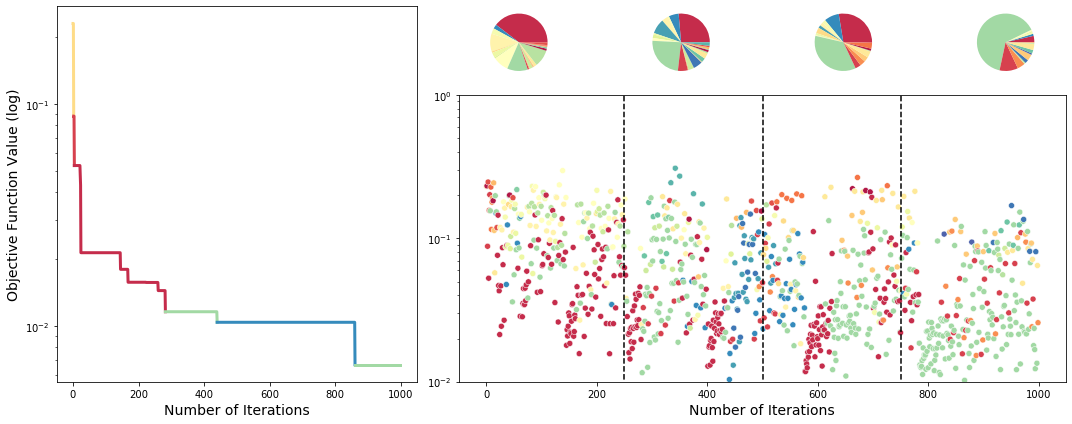

In [126]:
###FIGURE: Sample results
#TUNE ORDER MANUALLY
orders = ['R2-A1-N','N-A1-A1', 'R1-A1-A2', 'R2-R2-A2', 
       'R2-N-N', 'R2-R2-A1', 'R1-A1-N', 'R1-N-N', 'R2-N-A2', 'R1-R2-A1', 'N-N-N', 
       'R2-A1-A1', 'N-N-A1', 'N-R2-N', 'N-A1-N', 'N-R2-A1', 
       'N-R2-A2', 'R1-N-A1', 'R2-A1-A2', 'R1-A1-A1', 'R2-N-A1', 'R1-R2-N', 'R2-R2-N',
       'N-N-A2', 'N-A1-A2', 'R1-N-A2', 'R1-R2-A2']
palette = {}
pal = sns.color_palette('Spectral', len(orders))
for i in range(len(orders)):
    palette[orders[i]] = pal[i]


fig = plt.figure(figsize=(15, 6))
gs = gridspec.GridSpec(nrows=2, ncols=5, height_ratios=[1,4 ], width_ratios=[3, 1, 1, 1, 1])

ax = fig.add_subplot(gs[:, 0])
prev_c = 'Initial'
starts = []
archs = [prev_c]
for i in range(len(landscape)):
    c = landscape['Best Circuit'][i]
    if c != prev_c: 
        starts.append(i)
        archs.append(c)
        prev_c = c
starts
stops = starts[1:]
stops.append(len(landscape))

for start, stop, a in zip(starts, stops, archs[1:]):
    ax.plot(landscape.index[start:stop+1], landscape.best_losses[start:stop+1], color=palette[a], linewidth=3)
ax.set_ylabel('Objective Function Value (log)', fontsize=14)
ax.set_yscale('log')
ax.set_xlabel('Number of Iterations', fontsize=14)

ax = fig.add_subplot(gs[1, 1:])
ax.set_xlabel('Number of Iterations', fontsize=14)
ax.set_yscale('log')
ax.set_ylim([10E-3, 10E-1])
sns.scatterplot(x='index', y='loss', hue='Circuit', data=landscape, ax=ax, hue_order=orders, palette=palette, legend=False)
ax.vlines(250, 0, 10E9, linestyles='dashed')
ax.vlines(500, 0, 10E9, linestyles='dashed')
ax.vlines(750, 0, 10E9, linestyles='dashed')
ax.set_ylabel(None)


quarter1 = (landscape.iloc[0:250].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter2 = (landscape.iloc[250:500].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter3 = (landscape.iloc[500:750].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
quarter4 = (landscape.iloc[750:1000].sort_values(by='Circuit').groupby('Circuit').count().loss/200).reset_index()
colors = list(palette.values())

ax = fig.add_subplot(gs[0, 1])
ax.pie(quarter1.loss, colors=[palette[a] for a in quarter1.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 2])
ax.pie(quarter2.loss, colors=[palette[a] for a in quarter2.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 3])
ax.pie(quarter3.loss, colors=[palette[a] for a in quarter3.Circuit.unique().tolist()])

ax = fig.add_subplot(gs[0, 4])
ax.pie(quarter4.loss, colors=[palette[a] for a in quarter4.Circuit.unique().tolist()])

fig.tight_layout()
fig.savefig('sample_results.png', dpi=300)

In [ ]:
###Chemical robustness experiments

###FIGURE: Chemical robustness